In [2]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import re

import plotly.figure_factory as ff
import matplotlib.pyplot as plt

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [3]:
# My aim here is to start by answering the question of WHY the healthcare plan should adopt a food access program before 
# moving to where and how they should start it. This was not explicitly part of the assignment, but I think that it is important
# to address, the data is well-suited to getting at the "Why", and it should not take long.

In [4]:
# In order to persuade my audience, a healthcare plan, that they should adopt a food access program, I want to begin by 
# establishing a connection between food access and health.

In [5]:
# There are a few different metrics of low food access in the table, so I want to see how each relates to health outcomes.

In [6]:
# Before I do that, here is a key on dataframe names I use in this file for reference.

print('''
df1: Low access vs. 500 Cities Health Variables\n
df2: Low access, low income vs. 500 Cities Health variables\n
df3: Low access, SNAP Benefits vs. 500 Cities Health variables\n
df3_head: Low access, SNAP Benefits vs. 500 Cities Health variables, highest correlation variables\n
df4: Low access, SNAP Benefits vs. USDA Health Variables\n
df5: Low access seniors vs. 500 Cities Health Variables\n
df5_head: Low access seniors vs. 500 Cities Health Variables, highest correlation variables
''')


df1: Low access vs. 500 Cities Health Variables

df2: Low access, low income vs. 500 Cities Health variables

df3: Low access, SNAP Benefits vs. 500 Cities Health variables

df3_head: Low access, SNAP Benefits vs. 500 Cities Health variables, highest correlation variables

df4: Low access, SNAP Benefits vs. USDA Health Variables

df5: Low access seniors vs. 500 Cities Health Variables

df5_head: Low access seniors vs. 500 Cities Health Variables, highest correlation variables



In [7]:
# Low access vs. 500 Cities Health Variables

conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

cursor.execute("PRAGMA table_info(five_hundred_cities_summary)")
table_info_500c = cursor.fetchall()

exclude_columns = ['FIPS', 'StateAbbr', 'PlaceName', 'Total_Population2010', 'Access2_CrudePrev_weighted_average']  
health_columns_500c = [col[1] for col in table_info_500c if col[1] not in exclude_columns]

query = f"""
    SELECT a.PCT_LACCESS_POP10, {', '.join(health_columns_500c)}
    FROM access AS a
    JOIN five_hundred_cities_summary AS b ON a.FIPS = b.FIPS
"""

df1 = pd.read_sql(query, conn)

conn.close()

correlations = df1.corr()
df1_correlations = correlations['PCT_LACCESS_POP10'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_POP10:")
print(df1_correlations)

Correlations with PCT_LACCESS_POP10:
PCT_LACCESS_POP10                      1.000000
OBESITY_CrudePrev_weighted_avg         0.297891
ARTHRITIS_CrudePrev_weighted_avg       0.240483
CSMOKING_CrudePrev_weighted_avg        0.239154
COPD_CrudePrev_weighted_avg            0.220493
LPA_CrudePrev_weighted_avg             0.204829
BPHIGH_CrudePrev_weighted_avg          0.199940
CHD_CrudePrev_weighted_avg             0.183802
MHLTH_CrudePrev_weighted_avg           0.177442
PHLTH_CrudePrev_weighted_avg           0.159344
TEETHLOST_CrudePrev_weighted_avg       0.157810
BPMED_CrudePrev_weighted_avg           0.152962
STROKE_CrudePrev_weighted_avg          0.141127
HIGHCHOL_CrudePrev_weighted_avg        0.130376
ACCESS2_CrudePrev_weighted_avg         0.119588
DIABETES_CrudePrev_weighted_avg        0.112440
CASTHMA_CrudePrev_weighted_avg         0.107973
KIDNEY_CrudePrev_weighted_avg          0.102551
CANCER_CrudePrev_weighted_avg          0.099892
CHECKUP_CrudePrev_weighted_avg         0.074842
SLE

In [8]:
# Here, I found positive, but somewhat weak correlations between health outcomes and the LACCESS_POP10 variable.

In [9]:
# Low access, low income vs. 500 Cities Health variables

conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

query = f"""
    SELECT a.PCT_LACCESS_LOWI10, {', '.join(health_columns_500c)}
    FROM access AS a
    JOIN five_hundred_cities_summary AS b ON a.FIPS = b.FIPS
"""

df2 = pd.read_sql(query, conn)

conn.close()

correlations = df2.corr()
df2_correlations = correlations['PCT_LACCESS_LOWI10'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_LOWI10:")
print(df2_correlations)

Correlations with PCT_LACCESS_LOWI10:
PCT_LACCESS_LOWI10                     1.000000
ACCESS2_CrudePrev_weighted_avg         0.419859
OBESITY_CrudePrev_weighted_avg         0.397110
LPA_CrudePrev_weighted_avg             0.381471
BPHIGH_CrudePrev_weighted_avg          0.328694
DIABETES_CrudePrev_weighted_avg        0.308708
MHLTH_CrudePrev_weighted_avg           0.306270
PHLTH_CrudePrev_weighted_avg           0.301721
CHD_CrudePrev_weighted_avg             0.300098
KIDNEY_CrudePrev_weighted_avg          0.290495
STROKE_CrudePrev_weighted_avg          0.288441
CSMOKING_CrudePrev_weighted_avg        0.281751
COPD_CrudePrev_weighted_avg            0.276172
TEETHLOST_CrudePrev_weighted_avg       0.268984
HIGHCHOL_CrudePrev_weighted_avg        0.186011
ARTHRITIS_CrudePrev_weighted_avg       0.185326
BPMED_CrudePrev_weighted_avg           0.166325
SLEEP_CrudePrev_weighted_avg           0.080097
CHECKUP_CrudePrev_weighted_avg         0.038462
CASTHMA_CrudePrev_weighted_avg         0.036883
CA

In [10]:
# The correlations, between health outcomes and the PCT_LACCESS_LOWI10 variable, were a bit stronger.

In [11]:
# I still want to find a stronger correlation before I make my visualization, as I want it to indisputably show that
# low access to food is correlated with poor health outcomes. I am going to use the obesity metric from the "health" table,
# as it will include more rural data than exists in the 500 Cities database.

In [12]:
# Low access, SNAP Benefits vs. 500 Cities Health variables

conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

query = f"""
    SELECT a.PCT_LACCESS_SNAP15, {', '.join(health_columns_500c)}
    FROM access AS a
    JOIN five_hundred_cities_summary AS b ON a.FIPS = b.FIPS
"""

df3 = pd.read_sql(query, conn)

conn.close()

correlations = df3.corr()
df3_correlations = correlations['PCT_LACCESS_SNAP15'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_SNAP15:")
print(df3_correlations)

Correlations with PCT_LACCESS_SNAP15:
PCT_LACCESS_SNAP15                     1.000000
OBESITY_CrudePrev_weighted_avg         0.519407
BPHIGH_CrudePrev_weighted_avg          0.453884
LPA_CrudePrev_weighted_avg             0.448185
DIABETES_CrudePrev_weighted_avg        0.446743
STROKE_CrudePrev_weighted_avg          0.433447
KIDNEY_CrudePrev_weighted_avg          0.415999
PHLTH_CrudePrev_weighted_avg           0.412319
CHD_CrudePrev_weighted_avg             0.402858
ACCESS2_CrudePrev_weighted_avg         0.400973
COPD_CrudePrev_weighted_avg            0.396361
CSMOKING_CrudePrev_weighted_avg        0.393036
MHLTH_CrudePrev_weighted_avg           0.366704
TEETHLOST_CrudePrev_weighted_avg       0.362084
ARTHRITIS_CrudePrev_weighted_avg       0.327294
BPMED_CrudePrev_weighted_avg           0.293288
HIGHCHOL_CrudePrev_weighted_avg        0.268189
SLEEP_CrudePrev_weighted_avg           0.238855
CASTHMA_CrudePrev_weighted_avg         0.200808
CHECKUP_CrudePrev_weighted_avg         0.172158
CA

In [13]:
# The LACCESS_SNAP15 variable is even more strongly correlated with health outcomes, with obesity being the strongest correlation.

In [14]:
# One thing that I want to acknowledge is that, up to this point, I have been focusing exclusively on the health variables from 
# the 500 Cities database, as provided by the CDC, as opposed to those in the FDA Food Atlas database. This is because the 500 Cities 
# database is far more extensive in its level of detail on health: it includes datapoints for a number of diseases and behaviors,
# while the USDA database only includes data on obesity and diabetes. With that said, the 500 Cities database only represents 326 of the 
# 3143 counties in the U.S., and an especially urban subset of those counties at that. This gave me pause initially, but after further
# research into the counties that the CDC database includes, only 68 of them are actually classified as urban, with many counties
# that ostensibly exist within city limits still being totally rural, like the northern chunk of Abilene, TX for example.

# This is to say that the CDC database, which I am using for health outcomes, is not as representative as the USDA database,
# but for the purposes of this project I believe that its higher level of detail justifies its diminished geographic coverage.

In [15]:
# Out of curiosity, I still want to see if the USDA health metrics correlate as tightly with food access as the CDC health metrics do.

In [16]:
# Low access, SNAP Benefits vs. USDA Health Variable

conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

query = f"""
    SELECT a.PCT_LACCESS_SNAP15, b.PCT_DIABETES_ADULTS13, b.PCT_OBESE_ADULTS13
    FROM access AS a
    JOIN health AS b ON a.FIPS = b.FIPS
"""

df4 = pd.read_sql(query, conn)

conn.close()

correlations = df4.corr()
df4_correlations = correlations['PCT_LACCESS_SNAP15'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_SNAP15:")
print(df4_correlations)

Correlations with PCT_LACCESS_SNAP15:
PCT_LACCESS_SNAP15       1.000000
PCT_OBESE_ADULTS13       0.160679
PCT_DIABETES_ADULTS13    0.136373
Name: PCT_LACCESS_SNAP15, dtype: float64


In [17]:
# These correlations were fairly weak in comparison, so I am going to proceed with the 500 Cities (CDC) health data for my 
# first visualization.

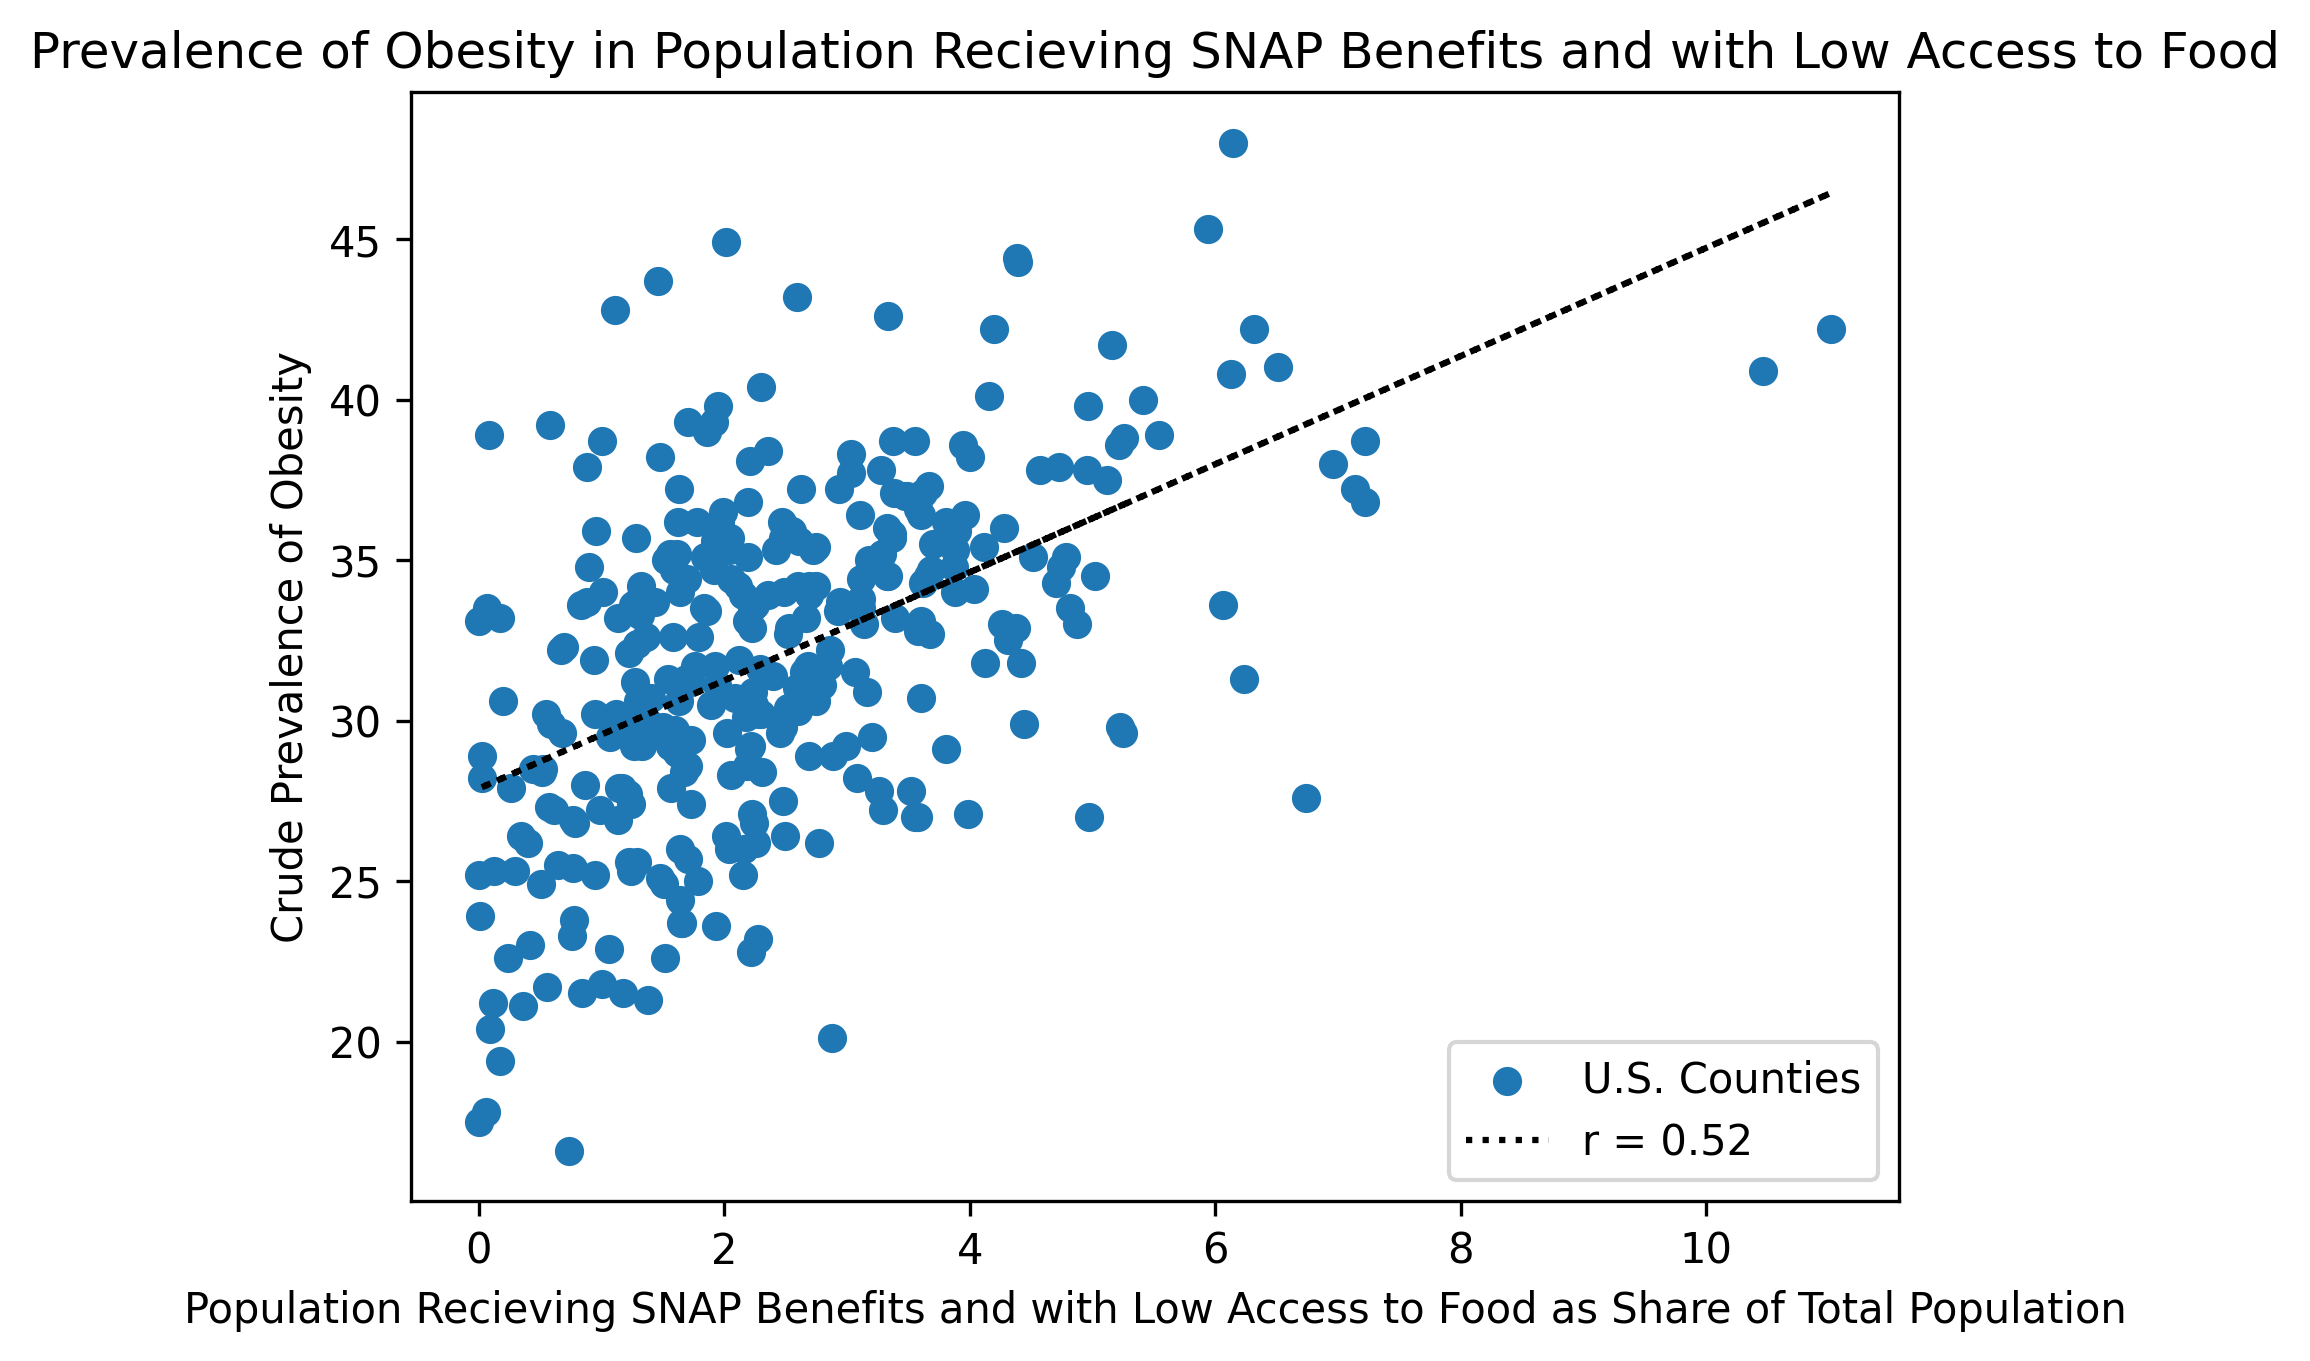

In [45]:
# I am setting up my matplotlib plotting framework as a function so that I can use it dynamically going forward.

def plot_access_vs_disease(df, x_col, y_col, x_var, disease_name, show=False, file_addendum=None):
    fig, ax = plt.subplots(dpi=300)
    
    df_clean = df.dropna(subset=[x_col])
    
    x = df_clean[x_col]
    y = df_clean[y_col].dropna()
    
    if len(x) != len(y):
        raise ValueError("x and y data lengths do not match after dropping NaNs")
    
    ax.scatter(x, y, label='U.S. Counties')
    
    coefficients = np.polyfit(x, y, 1)
    trendline = np.poly1d(coefficients)
    
    pearson_corr, _ = pearsonr(x, y)
    label = f'r = {pearson_corr:.2f}'
    
    ax.plot(x, trendline(x), color='black', linestyle='dotted', label=label)
    ax.legend()
    
    ax.set_title(f"Prevalence of {disease_name} in {x_var}")
    ax.set_xlabel(f"{x_var} as Share of Total Population")
    ax.set_ylabel(f'Crude Prevalence of {disease_name}')

    if file_addendum:
        plt.savefig(f'visualizations/{re.sub(r"\s+", "_", disease_name)}_{file_addendum}_access', bbox_inches='tight')
    else:
        plt.savefig(f'visualizations/{re.sub(r"\s+", "_", disease_name)}_access', bbox_inches='tight')
    
    if show:
        plt.show()
        
    plt.close()

# Plotting Low access, SNAP Benefits vs. Obesity

plot_access_vs_disease(
    df3,
    x_col='PCT_LACCESS_SNAP15',
    y_col='OBESITY_CrudePrev_weighted_avg',
    x_var='Population Recieving SNAP Benefits and with Low Access to Food',
    disease_name='Obesity',
    show=True
)

In [25]:
# I may use this visualization, but I want to check correlations for the PCT_LACCESS_SENIORS10 variable first, as that 
# may be more applicable to my audience, considering that I am presenting to a Medicare Advantage plan. Regardless, I am going
# to save this and a few other visualizations using the PCT_LACCESS_SNAP15 variable for my appendix, as they are effective for establishing
# that connection between food access and health if nothing else. 

In [46]:
# I am going to manipulate the correlation table a bit so that I can do make some plots dynamically, adding disease names (for ease of 
# making dynamic axis titles) and dropping columns that do not correspond as strictly to disease.


non_disease_columns = {
    'DENTAL_CrudePrev_weighted_avg', 
    'MAMMOUSE_CrudePrev_weighted_avg', 
    'LPA_CrudePrev_weighted_avg', 
    'PHLTH_CrudePrev_weighted_avg',
    'ACCESS2_CrudePrev_weighted_avg',
    'CHECKUP_CrudePrev_weighted_avg',
    'PAPTEST_CrudePrev_weighted_avg',
    'CHOLSCREEN_CrudePrev_weighted_avg',
    'COREM_CrudePrev_weighted_avg',
    'COREW_CrudePrev_weighted_avg',
    'COLON_SCREEN_CrudePrev_weighted_avg'
}

disease_map = {
    'OBESITY_CrudePrev_weighted_avg': 'Obesity',
    'BPHIGH_CrudePrev_weighted_avg': 'High Blood Pressure',
    'DIABETES_CrudePrev_weighted_avg': 'Diabetes',
    'STROKE_CrudePrev_weighted_avg': 'Stroke',
    'KIDNEY_CrudePrev_weighted_avg': 'Kidney Disease',
    'CHD_CrudePrev_weighted_avg': 'Coronary Heart Disease',
    'COPD_CrudePrev_weighted_avg': 'COPD',
    'CSMOKING_CrudePrev_weighted_avg': 'Smoking',
    'MHLTH_CrudePrev_weighted_avg': 'Mental Health',
    'TEETHLOST_CrudePrev_weighted_avg': 'Tooth Loss',
    'ARTHRITIS_CrudePrev_weighted_avg': 'Arthritis',
    'BPMED_CrudePrev_weighted_avg': 'Blood Pressure Medication',
    'HIGHCHOL_CrudePrev_weighted_avg': 'High Cholesterol',
    'SLEEP_CrudePrev_weighted_avg': 'Sleep Loss',
    'CASTHMA_CrudePrev_weighted_avg': 'Asthma',
    'CANCER_CrudePrev_weighted_avg': 'Cancer',
    'BINGE_CrudePrev_weighted_avg': 'Binge Drinking'
}


df3_head = df3_correlations.drop(df3_correlations.index[df3_correlations.index.isin(non_disease_columns) | df3_correlations.index.str.startswith('PCT')]).reset_index()
df3_head.columns = ['Variable', 'Correlation']
df3_head['Disease'] = df3_head['Variable'].map(disease_map)
df3_head = df3_head.iloc[1:7]

for index, row in df3_head.iterrows():
    plot_access_vs_disease(
        df3,
        x_col = 'PCT_LACCESS_SNAP15',
        y_col = row['Variable'],
        x_var = 'Population Recieving SNAP Benefits and with Low Access to Food',
        disease_name = row['Disease'],
        file_addendum= 'SNAP'
    )

In [39]:
# With these visualizations on deck in case I need them to broadly establish the connection between food access and health, I am
# going to focus on the PCT_LACCESS_SENIORS10 variable, as it may be more relevant to my audience.

In [47]:
# Low access seniors vs. 500 Cities Health Variables

conn = sqlite3.connect('challenge.db')
cursor = conn.cursor()

query = f"""
    SELECT a.PCT_LACCESS_SENIORS10, {', '.join(health_columns_500c)}
    FROM access AS a
    JOIN five_hundred_cities_summary AS b ON a.FIPS = b.FIPS
"""

df5 = pd.read_sql(query, conn)

correlations = df5.corr()
df5_correlations = correlations['PCT_LACCESS_SENIORS10'].sort_values(ascending=False)
print("Correlations with PCT_LACCESS_SENIORS10:")
print(df5_correlations)

Correlations with PCT_LACCESS_SENIORS10:
PCT_LACCESS_SENIORS10                  1.000000
CHD_CrudePrev_weighted_avg             0.441397
ARTHRITIS_CrudePrev_weighted_avg       0.436076
COPD_CrudePrev_weighted_avg            0.435265
STROKE_CrudePrev_weighted_avg          0.354815
CANCER_CrudePrev_weighted_avg          0.344107
PHLTH_CrudePrev_weighted_avg           0.339743
KIDNEY_CrudePrev_weighted_avg          0.329936
BPHIGH_CrudePrev_weighted_avg          0.323610
BPMED_CrudePrev_weighted_avg           0.317634
CSMOKING_CrudePrev_weighted_avg        0.315432
HIGHCHOL_CrudePrev_weighted_avg        0.298660
TEETHLOST_CrudePrev_weighted_avg       0.264408
OBESITY_CrudePrev_weighted_avg         0.262021
LPA_CrudePrev_weighted_avg             0.255734
DIABETES_CrudePrev_weighted_avg        0.245481
MHLTH_CrudePrev_weighted_avg           0.243625
CHECKUP_CrudePrev_weighted_avg         0.207418
CASTHMA_CrudePrev_weighted_avg         0.199623
SLEEP_CrudePrev_weighted_avg           0.126419

In [41]:
# This correlation table is promising because not only does it show some strong correlations (at least strong enough to be able to see
# the relationship in a scatter plot), but it also seems to highlight diseases which disproportionately affect older populations and would
# thus be of the most interest for my audience: CHD, arthritis, COPD, stroke, and cancer.

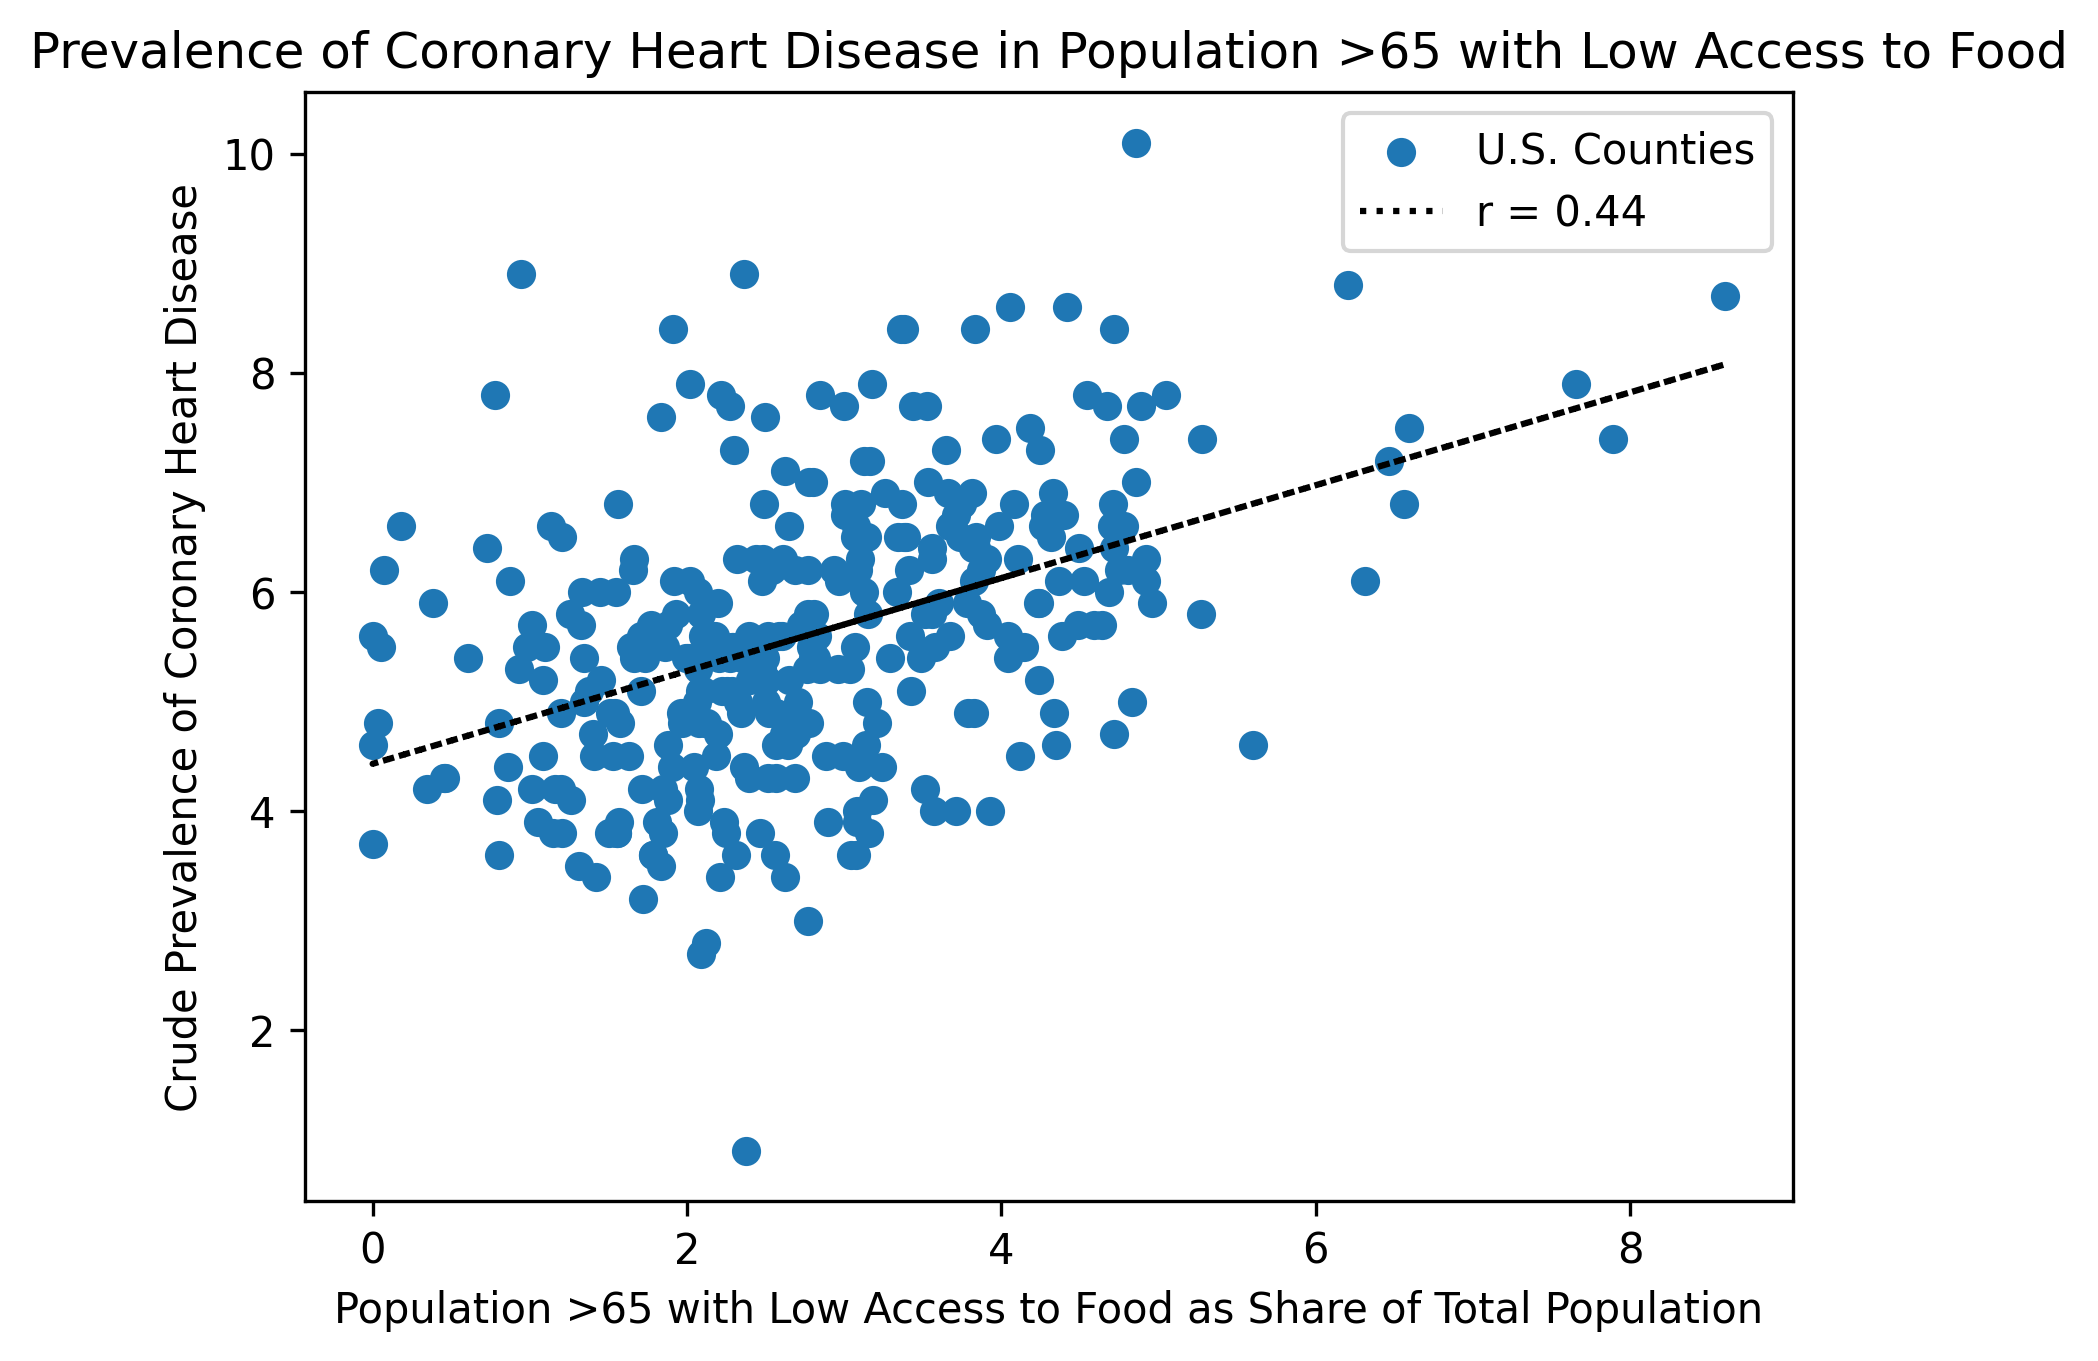

In [49]:
plot_access_vs_disease(
    df5,
    x_col='PCT_LACCESS_SENIORS10',
    y_col='CHD_CrudePrev_weighted_avg',
    x_var = 'Population >65 with Low Access to Food',
    disease_name='Coronary Heart Disease',
    file_addendum='seniors',
    show=True
)

In [43]:
# This seems more applicable to a Medicare Advantage plan, so I am going to use this in my presentation.

In [50]:
# Here, I will just generate some supplemental visualizations as I did before for the SNAP variable. 

df5_head = df5_correlations.drop(non_disease_columns).reset_index()
df5_head.columns = ['Variable', 'Correlation']
df5_head['Disease'] = df5_head['Variable'].map(disease_map)
df5_head = df5_head.iloc[1:7]

for index, row in df5_head.iterrows():
    plot_access_vs_disease(
        df5,
        x_col = 'PCT_LACCESS_SENIORS10',
        y_col = row['Variable'],
        x_var = 'Population >65 with Low Access to Food',
        disease_name = row['Disease'],
        file_addendum = 'seniors'
    )

In [33]:
# With these visualizations establishing a connection between food access and health, my next step will be to briefly address
# any concerns that the plan would have regarding taking on the responsibility of feeding its members.

In [34]:
# As you will see in my presentation, the three "objections" that I am predicting are (1) that nutrition interventions for seniors
# are futile, (2) that there are already programs like SNAP to address food insecurity, and (3) that the long-term savings would not
# outweigh the outlay required to start the program. 

In [35]:
# I am refuting the first of these with some scientific literature, but the second two I can address using the USDA/CDC data.

In [36]:
# Ideally, this presentation structure would have my audience totally on board with the idea of piloting a food access
# program before I start talking about ideas for implementation. 

In [ ]:
# Showing that government food assistance programs like SNAP do not adequately address food access disparities